# Data visualization

## Setup

In [1]:
import sys
import os
import subprocess

from six import string_types

# Make sure you have all of these packages installed, e.g. via pip
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from skimage import io
from scipy import ndimage
from IPython.display import display
%matplotlib inline

## Check dataset available

In [2]:
!ls -lha ./data

total 9712
drwxr-xr-x     10 tzaumiaan  staff   320B Feb  3 01:37 .
drwxr-xr-x@    11 tzaumiaan  staff   352B Feb  3 01:36 ..
-rw-r--r--@     1 tzaumiaan  staff   6.0K Feb  3 01:37 .DS_Store
-rw-r--r--@     1 tzaumiaan  staff   2.8M May  9  2017 sample_submission_v2.csv
drwx------@ 40671 tzaumiaan  staff   1.2M Jan 17 17:03 test-jpg
drwx------@ 20524 tzaumiaan  staff   641K Jan 17 16:30 test-jpg-additional
-rw-r-----@     1 tzaumiaan  staff   600K Jun  5  2017 test_v2_file_mapping.csv
drwx------@ 40482 tzaumiaan  staff   1.2M Jan 22 13:48 train-jpg
drwx------@    26 tzaumiaan  staff   832B Feb  3 00:03 train-tif
-rw-r--r--@     1 tzaumiaan  staff   1.4M May  9  2017 train_v2.csv


In [3]:
!ls -lha ./data/test-jpg | wc -l

   40672


## Specify the images and the labels

Set `PLANET_KAGGLE_ROOT` to the proper directory where we've got the TIFF and JPEG zip files, and accompanying CSVs.

In [4]:
PLANET_KAGGLE_ROOT = os.path.abspath("./data/")
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg')
PLANET_KAGGLE_TIFF_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-tif')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train_v2.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_TIFF_DIR)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

The labels are in a CSV entitled `train.csv`. Note that each image can be tagged with multiple tags. We'll convert them to a "one hot" style representation where each label is a column:

In [5]:
!ls -lha ./data/train_v2.csv

-rw-r--r--@ 1 tzaumiaan  staff   1.4M May  9  2017 ./data/train_v2.csv


First we take a look at the first few data

In [6]:
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [7]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
labels_df.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


Then we visualize the whole set of data with histogram, and check the cross relationaship between labels

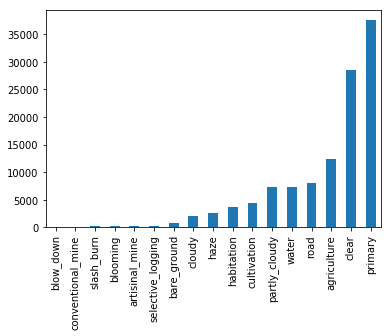

In [8]:
# Histogram of label instances
labels_df[label_list].sum().sort_values().plot.bar()

,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
haze,2697,2670,672,0,613,129,394,202,3,0,0,2,41,5,4,5,0
primary,2670,37513,11972,27668,7001,3469,7728,4455,209,0,7175,94,683,324,332,340,98
agriculture,672,11972,12315,9150,2712,2737,6034,3377,119,0,2493,24,225,38,32,65,22
clear,0,27668,9150,28431,5502,3090,6295,3527,173,0,0,70,747,307,311,308,85
water,613,7001,2712,5502,7411,915,2125,868,24,0,1295,26,206,299,16,49,3
habitation,129,3469,2737,3090,915,3660,2786,895,41,0,441,36,163,29,4,13,3
road,394,7728,6034,6295,2125,2786,8071,1294,36,0,1382,59,323,110,10,151,2
cultivation,202,4455,3377,3527,868,895,1294,4477,126,0,748,4,89,18,35,58,8
slash_burn,3,209,119,173,24,41,36,126,209,0,33,0,10,0,2,2,2
cloudy,0,0,0,0,0,0,0,0,0,2089,0,0,0,0,0,0,0


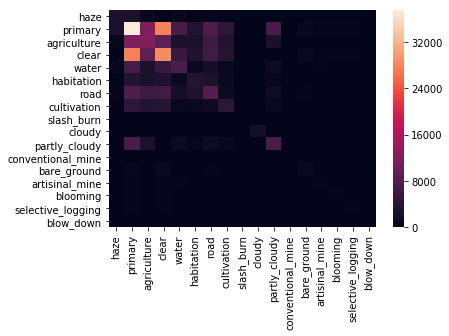

In [9]:
def make_cooccurence_matrix(labels):
    numeric_df = labels_df[labels]; 
    c_matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(c_matrix)
    return c_matrix
    
# Compute the co-ocurrence matrix
make_cooccurence_matrix(label_list)

Specifically in weather lables

,clear,partly_cloudy,haze,cloudy
clear,28431,0,0,0
partly_cloudy,0,7261,0,0
haze,0,0,2697,0
cloudy,0,0,0,2089


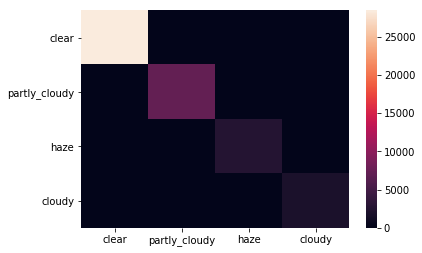

In [10]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
make_cooccurence_matrix(weather_labels)

And land lables

,primary,agriculture,water,cultivation,habitation
primary,37513,11972,7001,4455,3469
agriculture,11972,12315,2712,3377,2737
water,7001,2712,7411,868,915
cultivation,4455,3377,868,4477,895
habitation,3469,2737,915,895,3660


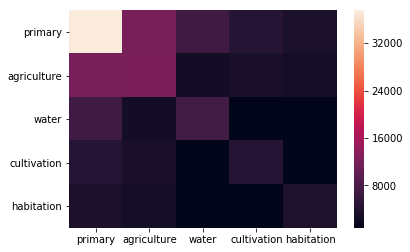

In [11]:
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation']
make_cooccurence_matrix(land_labels)

And finally the rare lables

,slash_burn,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
slash_burn,209,0,10,0,2,2,2
conventional_mine,0,100,10,4,0,0,0
bare_ground,10,10,862,40,3,13,4
artisinal_mine,0,4,40,339,0,6,0
blooming,2,0,3,0,332,7,1
selective_logging,2,0,13,6,7,340,1
blow_down,2,0,4,0,1,1,98


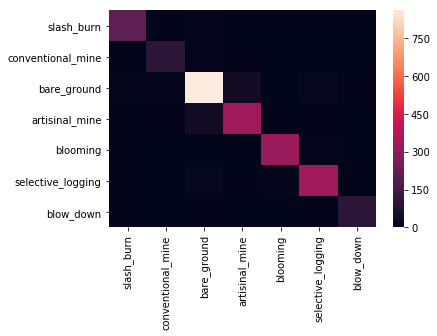

In [12]:
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
make_cooccurence_matrix(rare_labels)

## Inspect images
Let's display an image and visualize the pixel values. Here we will pick an image, load every single single band, then create RGB stack. The images here are JPEG, which are already color corrected, and each channel has 8-bit (0-255).

The files can be easily read into numpy arrays with the skimage.

In [13]:
def sample_images(tags, n=None):
    """Randomly sample n images with the specified tags."""
    condition = True
    if isinstance(tags, string_types):
        raise ValueError("Pass a list of tags, not a single tag.")
    for tag in tags:
        condition = condition & labels_df[tag] == 1
    if n is not None:
        return labels_df[condition].sample(n)
    else:
        return labels_df[condition]

In [14]:
def load_image(filename):
    '''Look through the directory tree to find the image you specified
    (e.g. train_10.tif vs. train_10.jpg)'''
    for dirname in os.listdir(PLANET_KAGGLE_ROOT):
        path = os.path.abspath(os.path.join(PLANET_KAGGLE_ROOT, dirname, filename))
        if os.path.exists(path):
            print('Found image {}'.format(path))
            return io.imread(path)
    # if you reach this line, you didn't find the image you're looking for
    print('Load failed: could not find image {}'.format(path))
    
def sample_to_fname(sample_df, row_idx, suffix='jpg'):
    '''Given a dataframe of sampled images, get the
    corresponding filename.'''
    fname = sample_df.get_value(sample_df.index[row_idx], 'image_name')
    return '{}.{}'.format(fname, suffix)

Let's look at an individual image. First, we'll plot a histogram of pixel values in each channel. Note how the intensities are distributed in a relatively narrow region of the dynamic range

In [15]:
def plot_rgb_histo(r, g, b):
    for slice_, name, color in ((r,'r', 'red'),(g,'g', 'green'),(b,'b', 'blue')):
        plt.hist(slice_.ravel(), bins=100, 
                 range=[0,255], 
                 label=name, color=color, histtype='step')
    plt.legend()

Found image /Users/tzaumiaan/DT/TUM/IN2346_DL4CV/final_project/data/train-jpg/train_10703.jpg


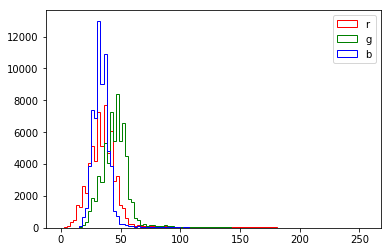

In [16]:
s = sample_images(['primary', 'water', 'road'], n=1)
fname = sample_to_fname(s, 0)

# find the image in the data directory and load it
rgb_image = load_image(fname)

# extract the different bands
r, g, b = rgb_image[:, :, 0], rgb_image[:, :, 1], rgb_image[:, :, 2]

# plot a histogram of rgb values
plot_rgb_histo(r, g, b)

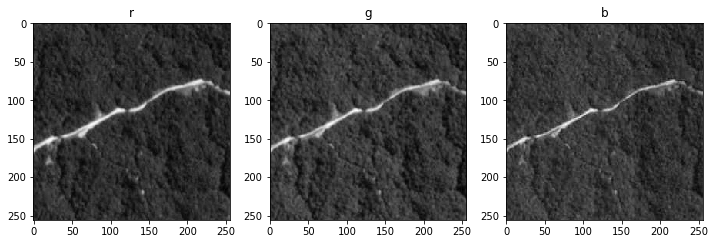

In [17]:
# Plot the bands
fig = plt.figure()
fig.set_size_inches(12, 4)
for i, (x, c) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'))):
    a = fig.add_subplot(1, 3, i+1)
    a.set_title(c)
    plt.imshow(x, cmap="gray")

The original color image looks like:

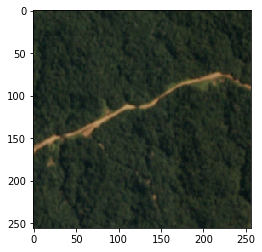

In [18]:
plt.imshow(rgb_image)

## Data augmentation
You might want to rotate, flip, or otherwise modify the images for training purposes. Note that the dimensions of the image changes:

Up: original with 4 angles
Down: mirrored with 4 angles


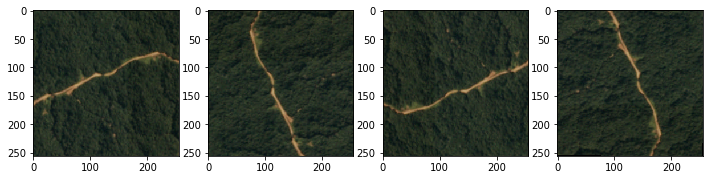

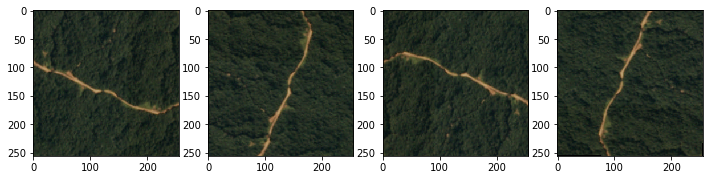

In [19]:
fig = plt.figure()
fig.set_size_inches(12, 4)
print("Up: original with 4 angles")
for i in range(4):
    a = fig.add_subplot(1, 4, i+1)
    rotated = scipy.ndimage.rotate(rgb_image, angle=(90*i))
    plt.imshow(rotated)

fig = plt.figure()
fig.set_size_inches(12, 4)
print("Down: mirrored with 4 angles")
mirror = rgb_image[::-1,:]
for i in range(4):
    a = fig.add_subplot(1, 4, i+1)
    rotated = scipy.ndimage.rotate(mirror, angle=(90*i))
    plt.imshow(rotated)

## TIFF and NIR information
Here we try to extract the 4 channels from TIFF and see what it is like...

Found image /Users/tzaumiaan/DT/TUM/IN2346_DL4CV/final_project/data/train-tif/train_10.tif
Found image /Users/tzaumiaan/DT/TUM/IN2346_DL4CV/final_project/data/train-jpg/train_10.jpg


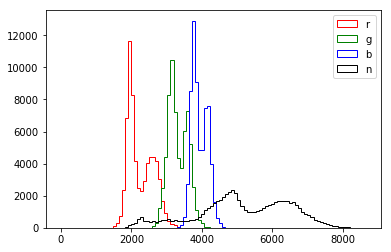

In [20]:
tiff_image = load_image('train_10.tif')
jpeg_image = load_image('train_10.jpg')
b = tiff_image[:, :, 0]
g = tiff_image[:, :, 1]
r = tiff_image[:, :, 2]
n = tiff_image[:, :, 3]
rgb_image[:,:,0] = r
rgb_image[:,:,1] = g
rgb_image[:,:,2] = b

# plot a histogram of rgbn values
def plot_rgbn_histo(r, g, b, n):
    for slice_, name, color in ((r,'r', 'red'),(g,'g', 'green'),(b,'b', 'blue'),(n,'n','black')):
        plt.hist(slice_.ravel(), bins=100, 
                 range=[0,tiff_image.max()], 
                 label=name, color=color, histtype='step')
    plt.legend()
plot_rgbn_histo(r, g, b, n)

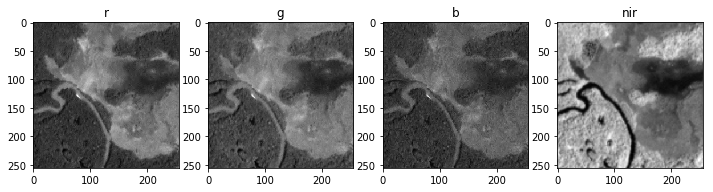

In [21]:
# Plot the bands
fig = plt.figure()
fig.set_size_inches(12, 4)
for i, (x, c) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'), (n, 'nir'))):
    a = fig.add_subplot(1, 4, i+1)
    a.set_title(c)
    plt.imshow(x, cmap="gray")

## Soil-adjusted vegetation index
From wikipedia, 
empirically derived NDVI products have been shown to be unstable, varying with soil colour, soil moisture, and saturation effects from high density vegetation. In an attempt to improve NDVI, Huete developed a vegetation index that accounted for the differential red and near-infrared extinction through the vegetation canopy. The index is a transformation technique that minimizes soil brightness influences from spectral vegetation indices involving red and near-infrared (NIR) wavelengths.

$ \text{SAVI} = \frac{(1+L)(\text{NIR}-\text{R})}{\text{NIR}+\text{R}+L}$

where $L$ is a canopy background adjustment factor. An $L$ value of 0.5 in reflectance space was found to minimize soil brightness variations and eliminate the need for additional calibration for different soils. The transformation was found to nearly eliminate soil-induced variations in vegetation indices.

Reference: https://en.wikipedia.org/wiki/Soil-adjusted_vegetation_index


In [22]:
savi = 1.5 * (n-r) / (0.5+n+r)

## Normalized difference water index

From wikipedia, ,
Normalized Difference Water Index (NDWI) may refer to one of at least two remote sensing-derived indexes related to liquid water.
It is used to monitor changes related to water content in water bodies, using green and NIR wavelengths, defined by McFeeters (1996):

$\text{NDWI}=\frac {\text{G}-\text{NIR}}{\text{G}+\text{NIR}}$

Reference: https://en.wikipedia.org/wiki/Normalized_difference_water_index

In [23]:
ndwi = (g-n)/(g+n)

## Visualize all the indices

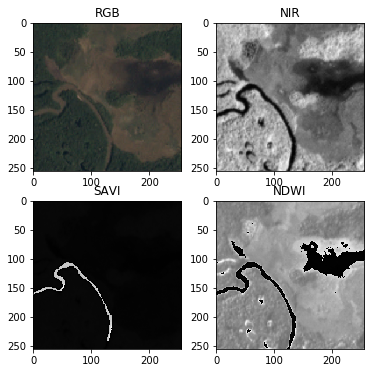

In [24]:
fig = plt.figure()
fig.set_size_inches(6, 6)

a = fig.add_subplot(2, 2, 1)
a.set_title('RGB')
plt.imshow(jpeg_image)

a = fig.add_subplot(2, 2, 2)
a.set_title('NIR')
plt.imshow(n, cmap="gray")

a = fig.add_subplot(2, 2, 3)
a.set_title('SAVI')
plt.imshow(savi, cmap="gray")

a = fig.add_subplot(2, 2, 4)
a.set_title('NDWI')
plt.imshow(ndwi, cmap="gray")